In [1]:
import gymnasium as gym
import random
import torch.nn as nn
import torch.optim as optim
import numpy as np 
from collections import deque
import torch
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Reacher-v4', render_mode = "human")



In [3]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
       self.memory = deque(maxlen = buffer_size)
       self.batch_size = batch_size
    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)
    

In [4]:
class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim      ):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()
    def forward(self, state):

        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x
    
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim + action_dim, hidden_dim) ## Adding Action_dim in between to improve stability acc. to paper. Can also add action dim to state dim in first layer
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(torch.cat([x, action], dim=1)))
        x = self.fc3(x)
        return x


In [5]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 400
buffer_size = 20000
batch_size = 256
num_episodes = 100
gamma = 0.99
tau = 0.001

class DDPG:
    def __init__(self, state_dim, action_dim, hidden_dim, buffer_size, batch_size, actor_lr, critic_lr,tau, gamma):
        self.actor = Actor(state_dim, hidden_dim, action_dim)
        self.actor_target = Actor(state_dim, hidden_dim, action_dim)
        self.critic = Critic(state_dim, action_dim, hidden_dim)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr = critic_lr)

        self.memory = ReplayBuffer(buffer_size, batch_size)
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma

        self._update_target_networks(tau=1)  # initialize target networks

    def act(self, state, noise=0.0):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return np.clip(action, -1, 1)
    
    def store_transition(self,state,action, reward, next_state, done):
        self.memory.add(state,action, reward, next_state, done)
    
    def learn(self):
        if len(self.memory)< batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample()

        states = torch.tensor(states, dtype = torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        ###Zero the gradients before updating the weights
        self.critic_optim.zero_grad()

        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q_values = self.critic_target(next_states, next_actions)
            target_q_values = rewards + self.gamma*target_q_values*(1-dones)

        current_q_values = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q_values, target_q_values)

        critic_loss.backward()
        self.critic_optim.step()

        ##Update actor weights
        self.actor_optim.zero_grad()

        actor_loss = -self.critic(states, self.actor(states)).mean()

        actor_loss.backward()
        self.actor_optim.step()

        self._update_target_networks()
    def _update_target_networks(self,tau = None):
        if tau is None:
            tau = self.tau

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)




In [6]:
agent = DDPG(state_dim,action_dim, hidden_dim, 200000, batch_size, 1e-4, 5e-4, tau, gamma)

In [7]:
Rewards =[]
for _ in range(num_episodes):
    state,info = env.reset()
    total_reward = 0
    for t in range(100):
        action = agent.act(state)
        next_state, reward,done, _, _ = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        agent.learn()
        state = next_state
        total_reward+=reward

        if done:
            break
    Rewards.append(total_reward)
        
    print(f'Episode {_}: Total reward = {total_reward}')



Episode {'reward_dist': -0.10895781864586403, 'reward_ctrl': -0.009391082}: Total reward = -14.966050064718209
Episode {'reward_dist': -0.05647627378911742, 'reward_ctrl': -0.008855247}: Total reward = -11.375003895252904


/tmp/ipykernel_13671/2543800611.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.tensor(states, dtype = torch.float32)


Episode {'reward_dist': -0.06930447978251927, 'reward_ctrl': -2.0}: Total reward = -76.44101293269254
Episode {'reward_dist': -0.1849928723576655, 'reward_ctrl': -2.0}: Total reward = -210.84064246949862
Episode {'reward_dist': -0.11657332806483756, 'reward_ctrl': -2.0}: Total reward = -209.99143702588245
Episode {'reward_dist': -0.12355968622972936, 'reward_ctrl': -2.0}: Total reward = -211.1790730003333
Episode {'reward_dist': -0.14796471221283392, 'reward_ctrl': -2.0}: Total reward = -215.30218738070562
Episode {'reward_dist': -0.16527296987966045, 'reward_ctrl': -2.0}: Total reward = -209.94074648332284
Episode {'reward_dist': -0.09707021267740773, 'reward_ctrl': -2.0}: Total reward = -207.77269724418738
Episode {'reward_dist': -0.17929050138648553, 'reward_ctrl': -2.0}: Total reward = -217.05253835574402
Episode {'reward_dist': -0.1440631597706303, 'reward_ctrl': -2.0}: Total reward = -216.24594691334175
Episode {'reward_dist': -0.11914028382270184, 'reward_ctrl': -2.0}: Total rew

Text(0.5, 0, 'Episodes')

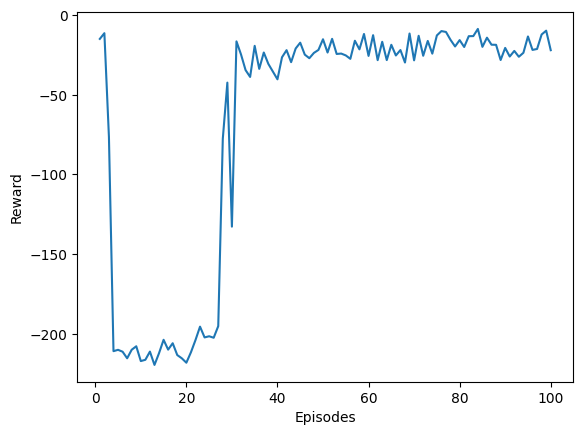

: 

In [8]:
episodes = [i for i in range(1,num_episodes+1)]
plt.plot(episodes, Rewards)

plt.ylabel("Reward")
plt.xlabel("Episodes")